In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms, datasets
from tqdm import tqdm
import numpy as np
from torch.amp import GradScaler, autocast
import timm
from timm.data import Mixup
from sklearn.metrics import roc_auc_score, recall_score, accuracy_score
from PIL import Image
from timm.models.convnext import ConvNeXtBlock
import torch.nn.functional as F
import pandas as pd
from sklearn.model_selection import train_test_split

c:\Users\10955\anaconda3\envs\vitiligo\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


self-supervied trainging

In [ ]:

class Config:
    augment_ratio = 4
    data_dir ='../../../../datasets/data.csv'
    img_size = 224
    patch_size = 8
    mask_ratio = 0.75
    batch_size = 8
    weight_decay = 0.05
    device = "cuda" if torch.cuda.is_available() else "cpu"
    num_epochs = 100
    learning_rate = 1e-4
    patience = 40
    save_dir = '../checkpoints/v1'
    resume_training = False
    def __init__(self):
        os.makedirs(self.save_dir, exist_ok=True)

config = Config()


In [3]:
class VitiligoDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform
        self.grouped = self.data.groupby(['pair_id', 'stability'])

    def __len__(self):
        return len(self.grouped.groups)

    def __getitem__(self, idx):
   
        pair_id, stability = list(self.grouped.groups.keys())[idx]
        pairs = self.grouped.get_group((pair_id, stability))
        clinic = pairs[pairs['image_type'] == 'clinic']
        wood = pairs[pairs['image_type'] == 'wood']
        clinic_path =  clinic['image_path'].values[0]
        wood_path = wood['image_path'].values[0]
        clinic_image = Image.open(clinic_path).convert('RGB')
        wood_image = Image.open(wood_path).convert('RGB')
        if self.transform:
            clinic_image = self.transform(clinic_image)
            wood_image = self.transform(wood_image)
        label = 1 if stability == 'stable' else 0
        label = torch.tensor(label, dtype=torch.long)
        return clinic_image, wood_image, label



In [ ]:
backbone = timm.create_model("convnextv2_tiny", checkpoint_path="../../../../outputs/checkpoints/proposed/pytorch_model.bin")

def count_layers(model, depth=0):
    layer_count = 0
    for _, child in model.named_children():
        layer_count += 1
        layer_count += count_layers(child, depth + 1)
    return layer_count

total_layers = count_layers(backbone)
print(f"\nTotal layers (recursive count): {total_layers}")


Total layers (recursive count): 248


dataloader

In [ ]:
from collections import Counter

backbone = timm.create_model("convnextv2_tiny", checkpoint_path='../../../../outputs/checkpoints/proposed/pytorch_model.bin')
transform = timm.data.create_transform(**timm.data.resolve_data_config(backbone.pretrained_cfg))
dataset = VitiligoDataset(csv_file='../../../../datasets/data.csv',  transform=transform)
train_ids, val_ids = train_test_split(range(len(dataset)), test_size=0.2, random_state=42)
train_dataset = Subset(dataset, train_ids)
val_dataset = Subset(dataset, val_ids)
train_loader = DataLoader(train_dataset, batch_size=Config.batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=Config.batch_size, shuffle=False)
train_labels = []
for _, _, label in train_dataset:
    train_labels.append(label.item())
class_counts = Counter(train_labels)
total_samples = len(train_labels)
class_percentages = {cls: count / total_samples * 100 for cls, count in class_counts.items()}
print("Distribution:")
for cls, count in class_counts.items():
    print(f"Classes {cls}: {count} samples ({class_percentages[cls]:.2f}%)")


Distribution:
Classes 1: 245 samples (50.62%)
Classes 0: 239 samples (49.38%)


Model

In [ ]:
class ConvQKVAttention(nn.Module):
    def __init__(self, in_channels, out_channels=None):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels or in_channels
        self.q_conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.k_conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.v_conv = nn.Conv2d(2 * in_channels, out_channels, kernel_size=3, padding=1)
        self.fusion = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size=1),
            nn.GELU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=1)
        )
    def forward(self, x1, x2):
        q = self.q_conv(x2) 
        k = self.k_conv(x1)  
        attention_scores = torch.sum(q * k, dim=1, keepdim=True) 
        attention_weights = torch.softmax(attention_scores, dim=1)  
        v_input = torch.cat([x1, x2], dim=1)  
        v = self.v_conv(v_input)  
        attended_v = v * attention_weights 
        fused_features = self.fusion(attended_v)
        return fused_features, attention_weights

class ConvNeXtV2MAE(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.encoder = timm.create_model(
            "convnextv2_tiny",
            checkpoint_path='../../../../outputs/checkpoints/proposed/pytorch_model.bin')
        self.encoder.head = nn.Identity()
        for param in self.encoder.parameters():
            param.requires_grad = False
        for param in self.encoder.stages[-2:].parameters():
            param.requires_grad = True
        
        self.encoder_dim = 768
        self.encoder_proj = nn.Conv2d(self.encoder_dim, 384, kernel_size=1)
        decoder_dim = 384
        self.decoder_blocks = nn.Sequential(
            ConvNeXtBlock(decoder_dim, drop_path=0.0),
            ConvNeXtBlock(decoder_dim, drop_path=0.0),
            ConvNeXtBlock(decoder_dim, drop_path=0.0),
            ConvNeXtBlock(decoder_dim, drop_path=0.0),
        )
        self.upsample = nn.Sequential(
            nn.ConvTranspose2d(decoder_dim, decoder_dim//2, kernel_size=2, stride=2),
            ConvNeXtBlock(decoder_dim//2, drop_path=0.0),
            nn.ConvTranspose2d(decoder_dim//2, decoder_dim//4, kernel_size=2, stride=2),
            ConvNeXtBlock(decoder_dim//4, drop_path=0.0),
            nn.ConvTranspose2d(decoder_dim//4, decoder_dim//8, kernel_size=2, stride=2),
            ConvNeXtBlock(decoder_dim//8, drop_path=0.0),
            nn.ConvTranspose2d(decoder_dim//8, decoder_dim//16, kernel_size=2, stride=2),
            ConvNeXtBlock(decoder_dim//16, drop_path=0.0),
            nn.ConvTranspose2d(decoder_dim//16, decoder_dim//32, kernel_size=2, stride=2),
            nn.Conv2d(decoder_dim//32, 3, kernel_size=1),
        )
        

        
        self.head = nn.Linear(384, 2)
        
        
        self.mask_generator = MaskGenerator(
            input_size=config.img_size,
            patch_size=config.patch_size,
            mask_ratio=config.mask_ratio
        )
        self.conv_qkv_attention = ConvQKVAttention(
            in_channels=384, out_channels=384
        )
        
    def get_global_context(self, c_img, w_img):
  
        x1 = self.encoder.forward_features(c_img) 
        x2 = self.encoder.forward_features(w_img)  
        

        x1 = self.encoder_proj(x1) 
        x2 = self.encoder_proj(x2) 
        
    
        fused_features, attention_map = self.conv_qkv_attention(x1, x2)
 
        
    
        global_features = fused_features.mean(dim=(2, 3))  
        
        return global_features, attention_map

    def forward_encoder(self, w_img, mask):

        masked_x = self.generate_masked_image(w_img, mask)

        x = self.encoder.forward_features(masked_x)  
        x = self.encoder_proj(x)  
        return x, mask
    
    def forward_decoder(self, x, mask):

        x = self.decoder_blocks(x)
        x = self.upsample(x)
        return x, mask
    
    def forward_classification(self, c_img, w_img):

        features, _ = self.get_global_context(c_img, w_img)
        logits = self.head(features)
        return logits
    
    def forward_loss(self, c_img, w_img, pred, mask, labels=None, mae_weight=1.0, cls_weight=10):

  
        p = self.config.patch_size
        h, w = w_img.shape[2]//p, w_img.shape[3]//p
        mask = torch.as_tensor(mask, dtype=torch.bool, device=pred.device)
        mask = mask.reshape(-1, 1, h, w)
        mask = F.interpolate(mask.float(), scale_factor=p, mode='nearest').bool()

        mae_loss = (pred - w_img) ** 2
        mae_loss = mae_loss.mean(dim=1)  
        mae_loss = (mae_loss * (~mask.squeeze(1))).sum() / (~mask).sum()
        
        cls_loss = 0
        if labels is not None:
            logits = self.forward_classification(c_img, w_img)
            cls_loss = F.cross_entropy(logits, labels)
        
        total_loss = mae_weight * mae_loss + cls_weight * cls_loss
        
        return {
            'total_loss': total_loss,
            'mae_loss': mae_loss,
            'cls_loss': cls_loss
        }
    
    
    def generate_masked_image(self, x, mask):

        p = self.config.patch_size
        h, w = x.shape[2]//p, x.shape[3]//p
        mask = torch.as_tensor(mask, dtype=torch.float32, device=x.device)
        mask = mask.reshape(-1, 1, h, w)
        mask = F.interpolate(mask, scale_factor=p, mode='nearest')
        return x * mask
    
    
    def forward(self, c_img, w_img, labels):

        mask = self.mask_generator()
        mask = mask.to(w_img.device)
        mask = mask.repeat(w_img.shape[0], 1)
 
        
        x, mask = self.forward_encoder(w_img, mask)
        
        pred, mask = self.forward_decoder(x, mask)
    
        loss = self.forward_loss(c_img, w_img, pred, mask, labels=labels)
        return loss, pred, mask


class MaskGenerator:
    def __init__(self, input_size=Config.img_size, patch_size=16, mask_ratio=0.75):
        self.input_size = input_size
        self.patch_size = patch_size
        self.mask_ratio = mask_ratio
        self.num_patches = (input_size // patch_size) ** 2
        self.num_masked = int(self.num_patches * mask_ratio)
    
    def __call__(self):

        mask_indices = np.random.permutation(self.num_patches)[:self.num_masked]
        mask = np.ones(self.num_patches, dtype=np.int64)
        mask[mask_indices] = 0  
        mask = torch.tensor(mask, dtype=torch.bool)
        return mask


Visulization

In [7]:
import matplotlib.pyplot as plt
import cv2


def visualize(model, data_loader, config, num_samples=4, save_path=None):

    model.eval()
    device = config.device
    model = model.to(device)
    
    with torch.no_grad():

        for i, (clinic_images, wood_images, labels) in enumerate(data_loader):
            if i >= 1:
                break
                

            clinic_images = clinic_images.to(device)[:num_samples]
            wood_images = wood_images.to(device)[:num_samples]
            labels = labels.to(device)[:num_samples]
            

            _, pred, mask = model(clinic_images, wood_images, labels)
            _, attention_maps = model.get_global_context(clinic_images, wood_images)
            

            mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1)
            std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1)
 
            images = wood_images.detach().cpu()
            images = images * std + mean
            pred = pred.detach().cpu()
            pred = pred * std + mean
            

            p = config.patch_size
            h, w = images.shape[2] // p, images.shape[3] // p
            mask_cpu = mask[0].detach().cpu().reshape(1, 1, h, w)
            mask_cpu = F.interpolate(mask_cpu.float(), size=(images.shape[2], images.shape[3]), mode='nearest')
            mask_cpu = mask_cpu.repeat(1, 3, 1, 1)
            

            attention_maps = attention_maps.detach().cpu()
            wood_images_np = wood_images.detach().cpu() * std + mean
            wood_images_np = wood_images_np.clamp(0, 1)
            
    
            fig, axes = plt.subplots(num_samples, 4, figsize=(20, 5 * num_samples))
            
            for i in range(num_samples):

                img_original = images[i].permute(1, 2, 0).numpy()
                axes[i, 0].imshow(img_original.clip(0, 1))
                axes[i, 0].set_title("Original Image")
                axes[i, 0].axis('off')
                

                masked_img = images[i] * mask_cpu[0].numpy()
                axes[i, 1].imshow(masked_img.permute(1, 2, 0).clip(0, 1))
                axes[i, 1].set_title("Masked Image")
                axes[i, 1].axis('off')
                

                img_reconstructed = pred[i].permute(1, 2, 0).numpy()
                axes[i, 2].imshow(img_reconstructed.clip(0, 1))
                axes[i, 2].set_title("Reconstructed Image")
                axes[i, 2].axis('off')
                

                attn_map = attention_maps[i, 0].numpy()
                attn_map = (attn_map - attn_map.min()) / (attn_map.max() - attn_map.min() + 1e-8)
                attn_resized = cv2.resize(attn_map, (img_original.shape[1], img_original.shape[0]))
                
                heatmap = cv2.applyColorMap((attn_resized * 255).astype(np.uint8), cv2.COLORMAP_JET)
                heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0
                overlay = cv2.addWeighted(img_original, 0.6, heatmap, 0.4, 0)
                
                axes[i, 3].imshow(overlay)
                axes[i, 3].set_title("Attention Heatmap")
                axes[i, 3].axis('off')
            
            plt.tight_layout()
            

            if save_path:
                plt.savefig(save_path, dpi=300, bbox_inches='tight')
            else:
                plt.show()
            
            break

C:\Temp\ipykernel_69336\3445480146.py:58: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  masked_img = images[i] * mask_cpu[0].numpy()


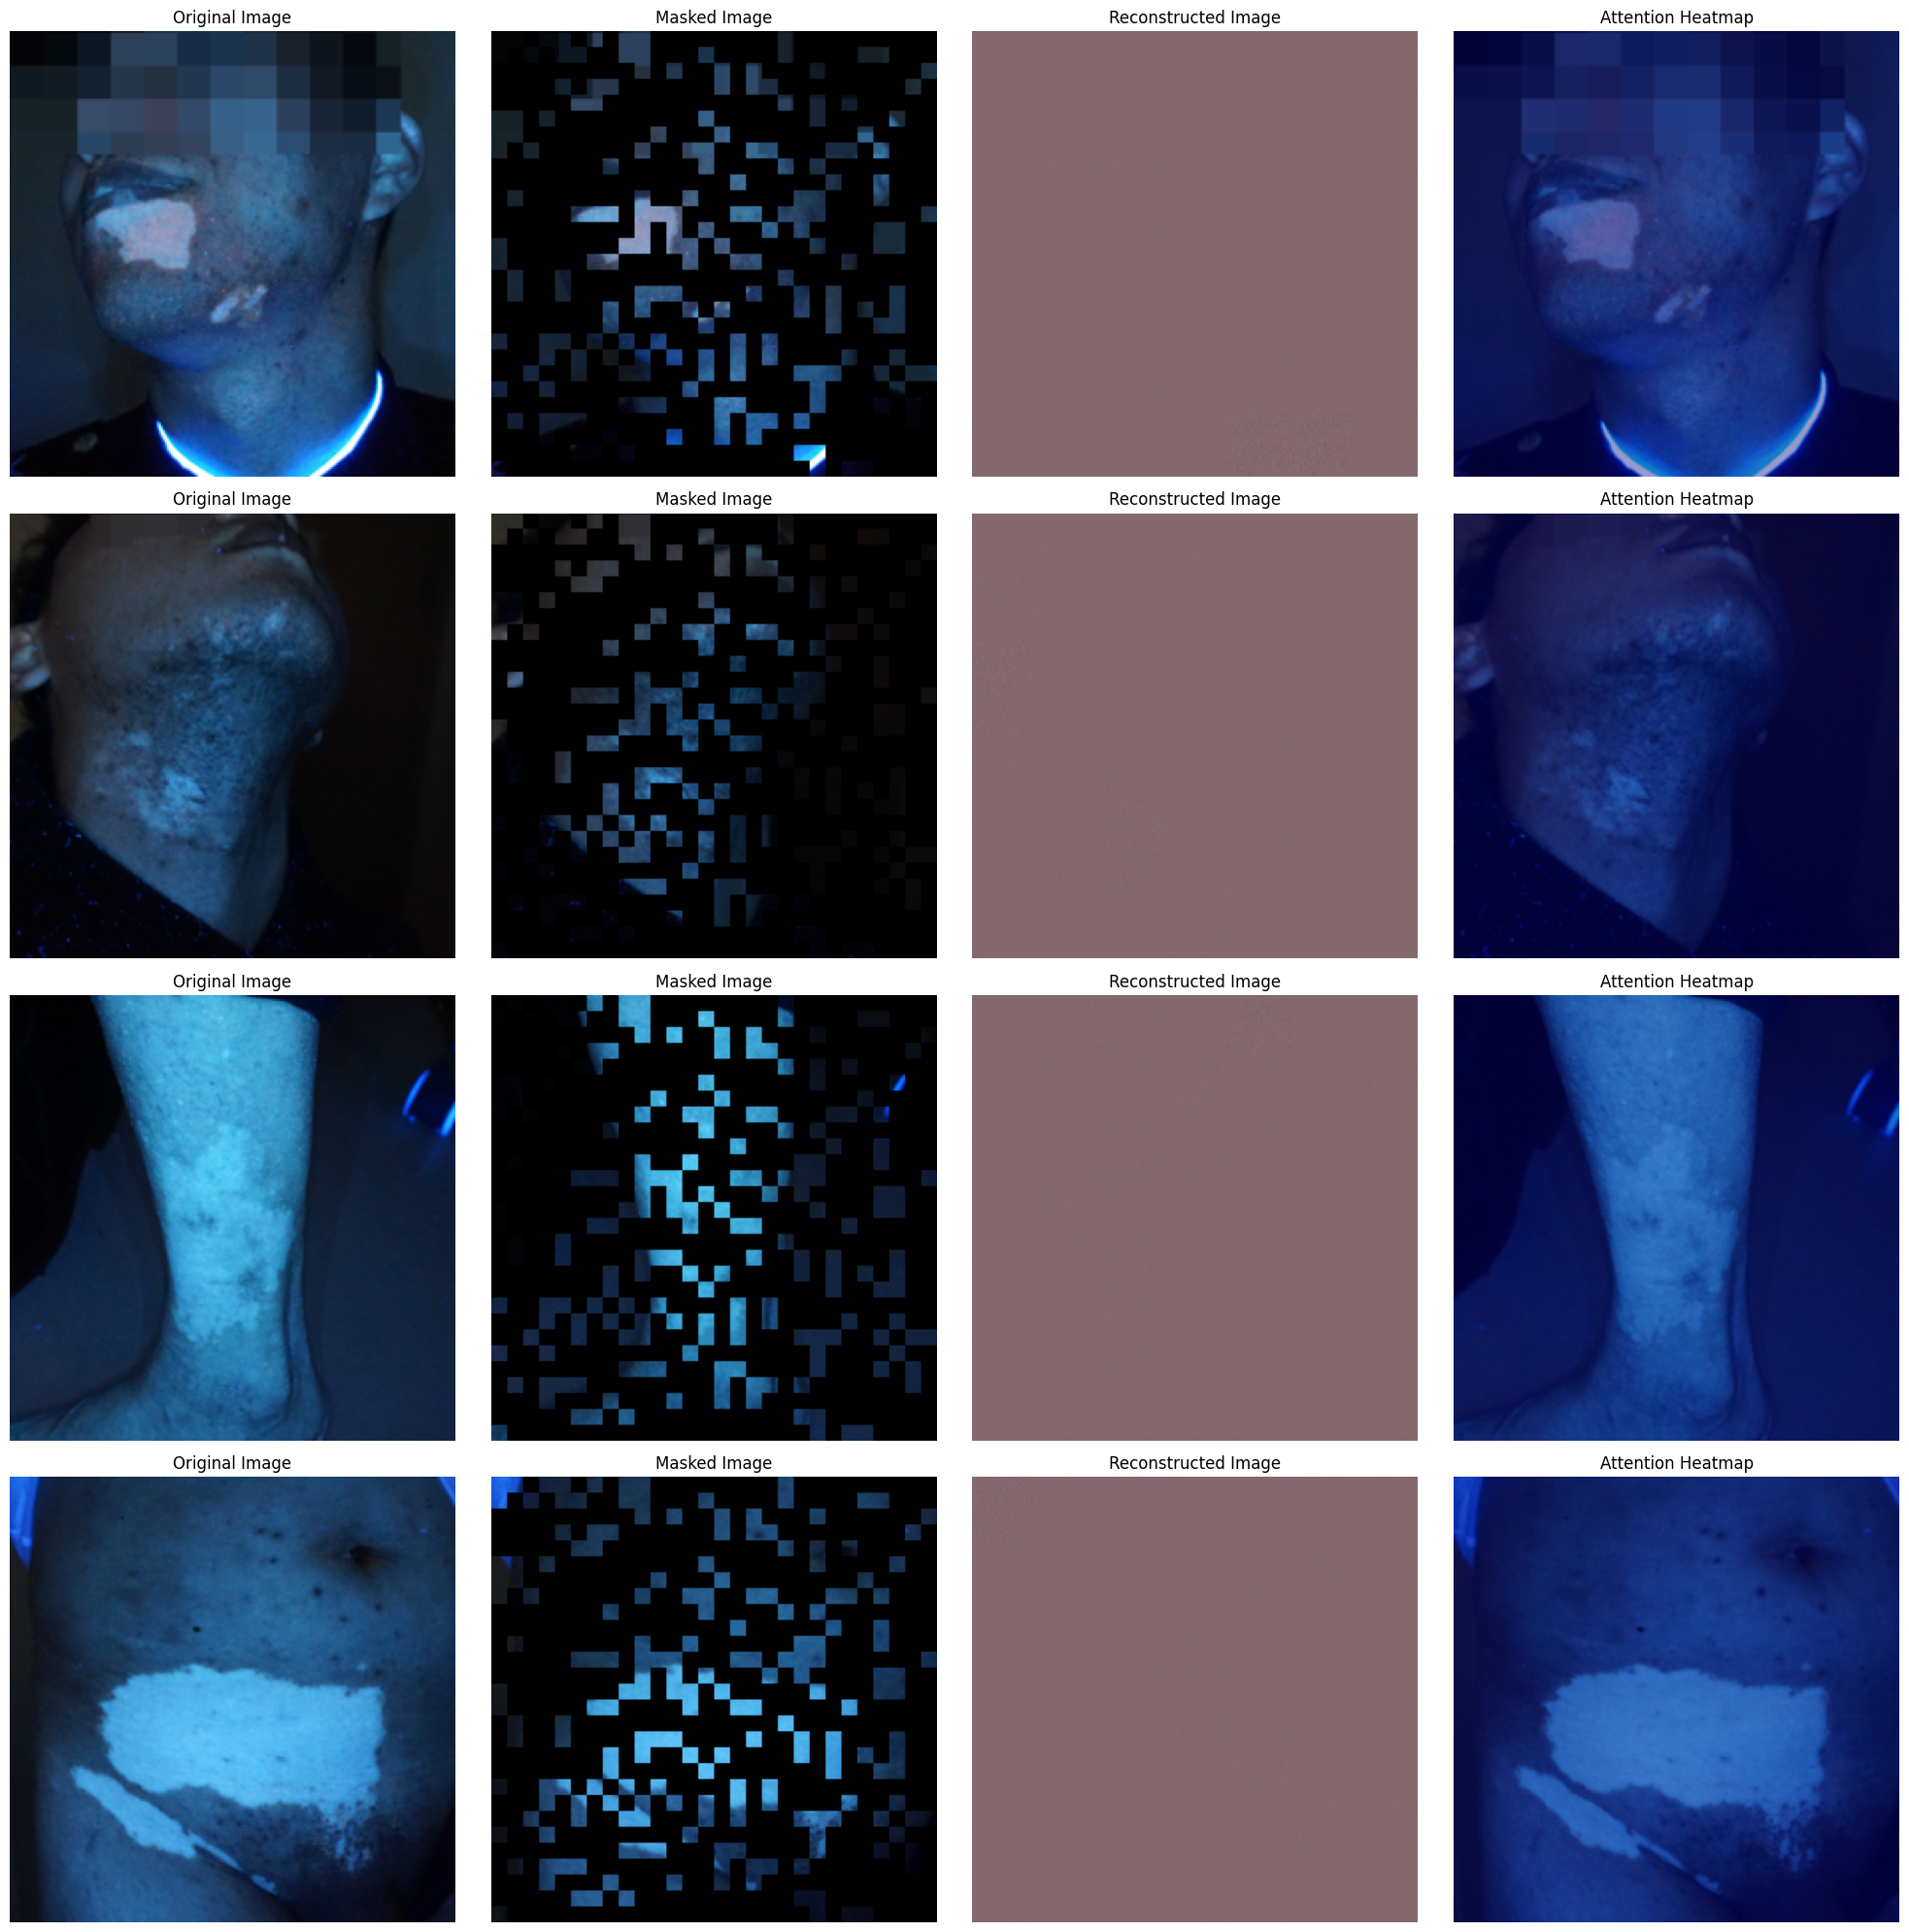

In [8]:
model = ConvNeXtV2MAE(Config).to(Config.device)

visualize(model, train_loader, Config, num_samples=4, save_path=None)

Test

In [9]:
config = Config()
model = ConvNeXtV2MAE(config).to(config.device)
model.train()
c_img, w_img, labels = next(iter(train_loader))
c_img, w_img, labels = c_img.to(config.device), w_img.to(config.device), labels.to(config.device)
loss_dict, _, _ = model(c_img, w_img, labels)
print(loss_dict)



{'total_loss': tensor(8.6491, device='cuda:0', grad_fn=<AddBackward0>), 'mae_loss': tensor(1.6722, device='cuda:0', grad_fn=<DivBackward0>), 'cls_loss': tensor(0.6977, device='cuda:0', grad_fn=<NllLossBackward0>)}


In [10]:
from sklearn.metrics import precision_score, confusion_matrix 
model.eval()
with torch.no_grad():
    c_img, w_img, labels = next(iter(val_loader))
    c_img, w_img, labels = c_img.to(config.device), w_img.to(config.device), labels.to(config.device)
    logits = model.forward_classification(c_img, w_img)
    preds = torch.argmax(logits, dim=1)
    print(f"样本logits: {logits[0].cpu().numpy()}")
    print(f"对应预测: {preds[0].item()}")
    print(f"真实标签: {labels[0].item()}")        
precision = precision_score(labels.cpu().numpy(), preds.cpu().numpy())

cm = confusion_matrix(labels.cpu().numpy(), preds.cpu().numpy())
tn, fp, fn, tp = cm.ravel() 
specificity = tn / (tn + fp) 

print(precision, specificity)


样本logits: [-0.0472795  -0.20888072]
对应预测: 0
真实标签: 0
0.0 0.8333333333333334


Epoch 1/100: 100%|██████████| 61/61 [02:33<00:00,  2.51s/it, cls=0.7371, loss=8.2592, mae=0.8885]



Epoch 1 - Train: cls=0.6881, mae=1.6946, loss=8.5756, precision=0.6667, specificity=0.6611, recall=0.6612, f1=0.6639, auc=0.7708, accuracy=0.6612
Epoch 1 - Val: cls=0.6427, mae=0.9844, precision=0.5978, specificity=0.3729, recall=0.8871, f1=0.7143, auc=0.7280, accuracy=0.6364
★ Saved best model: best_model_p0.5978_s0.3729_f10.7143.pth
Checkpoint saved at epoch 1


Epoch 2/100: 100%|██████████| 61/61 [02:32<00:00,  2.50s/it, cls=0.1640, loss=2.3102, mae=0.6698]



Epoch 2 - Train: cls=0.4060, mae=0.6875, loss=4.7479, precision=0.9510, specificity=0.9498, recall=0.9510, f1=0.9510, auc=0.9854, accuracy=0.9504
Epoch 2 - Val: cls=0.6972, mae=0.6613, precision=0.7895, specificity=0.8644, recall=0.4839, f1=0.6000, auc=0.7840, accuracy=0.6694
★ Saved best model: best_model_p0.7895_s0.8644_f10.6000.pth
Checkpoint saved at epoch 2


Epoch 3/100: 100%|██████████| 61/61 [02:32<00:00,  2.50s/it, cls=0.1004, loss=1.4934, mae=0.4892]



Epoch 3 - Train: cls=0.1434, mae=0.5636, loss=1.9972, precision=0.9959, specificity=0.9958, recall=0.9918, f1=0.9939, auc=0.9997, accuracy=0.9938
Epoch 3 - Val: cls=1.0802, mae=0.6000, precision=0.8462, specificity=0.9322, recall=0.3548, f1=0.5000, auc=0.8434, accuracy=0.6364


Epoch 4/100: 100%|██████████| 61/61 [02:31<00:00,  2.49s/it, cls=0.0011, loss=0.2277, mae=0.2167]



Epoch 4 - Train: cls=0.0598, mae=0.3857, loss=0.9840, precision=1.0000, specificity=1.0000, recall=1.0000, f1=1.0000, auc=1.0000, accuracy=1.0000
Epoch 4 - Val: cls=0.8735, mae=0.3314, precision=0.7215, specificity=0.6271, recall=0.9194, f1=0.8085, auc=0.8633, accuracy=0.7769
★ Saved best model: best_model_p0.7215_s0.6271_f10.8085.pth
Checkpoint saved at epoch 4


Epoch 5/100: 100%|██████████| 61/61 [02:30<00:00,  2.47s/it, cls=0.0196, loss=0.5478, mae=0.3519]



Epoch 5 - Train: cls=0.0311, mae=0.2454, loss=0.5566, precision=1.0000, specificity=1.0000, recall=1.0000, f1=1.0000, auc=1.0000, accuracy=1.0000
Epoch 5 - Val: cls=1.2196, mae=0.2711, precision=0.8065, specificity=0.8983, recall=0.4032, f1=0.5376, auc=0.8253, accuracy=0.6446
Checkpoint saved at epoch 5


Epoch 6/100: 100%|██████████| 61/61 [02:30<00:00,  2.46s/it, cls=0.0000, loss=0.1924, mae=0.1919]



Epoch 6 - Train: cls=0.0134, mae=0.2191, loss=0.3536, precision=1.0000, specificity=1.0000, recall=1.0000, f1=1.0000, auc=1.0000, accuracy=1.0000
Epoch 6 - Val: cls=1.1612, mae=0.2452, precision=0.7937, specificity=0.7797, recall=0.8065, f1=0.8000, auc=0.8576, accuracy=0.7934
★ Saved best model: best_model_p0.7937_s0.7797_f10.8000.pth
Checkpoint saved at epoch 6


Epoch 7/100: 100%|██████████| 61/61 [02:30<00:00,  2.47s/it, cls=0.0000, loss=0.1314, mae=0.1309]



Epoch 7 - Train: cls=0.0655, mae=0.2077, loss=0.8630, precision=1.0000, specificity=1.0000, recall=1.0000, f1=1.0000, auc=1.0000, accuracy=1.0000
Epoch 7 - Val: cls=0.7100, mae=0.2413, precision=0.7455, specificity=0.7627, recall=0.6613, f1=0.7009, auc=0.8368, accuracy=0.7107


Epoch 8/100: 100%|██████████| 61/61 [02:30<00:00,  2.46s/it, cls=0.0000, loss=0.1675, mae=0.1675]



Epoch 8 - Train: cls=0.0065, mae=0.1972, loss=0.2621, precision=1.0000, specificity=1.0000, recall=1.0000, f1=1.0000, auc=1.0000, accuracy=1.0000
Epoch 8 - Val: cls=1.0504, mae=0.2396, precision=0.7857, specificity=0.7966, recall=0.7097, f1=0.7458, auc=0.8425, accuracy=0.7521


Epoch 9/100: 100%|██████████| 61/61 [02:29<00:00,  2.45s/it, cls=0.0000, loss=0.1734, mae=0.1732]



Epoch 9 - Train: cls=0.0002, mae=0.1838, loss=0.1862, precision=1.0000, specificity=1.0000, recall=1.0000, f1=1.0000, auc=1.0000, accuracy=1.0000
Epoch 9 - Val: cls=1.0398, mae=0.2225, precision=0.7869, specificity=0.7797, recall=0.7742, f1=0.7805, auc=0.8439, accuracy=0.7769


Epoch 10/100: 100%|██████████| 61/61 [02:29<00:00,  2.46s/it, cls=0.0002, loss=0.1642, mae=0.1625]



Epoch 10 - Train: cls=0.0001, mae=0.1771, loss=0.1779, precision=1.0000, specificity=1.0000, recall=1.0000, f1=1.0000, auc=1.0000, accuracy=1.0000
Epoch 10 - Val: cls=1.0471, mae=0.2164, precision=0.7869, specificity=0.7797, recall=0.7742, f1=0.7805, auc=0.8447, accuracy=0.7769
Checkpoint saved at epoch 10


Epoch 11/100: 100%|██████████| 61/61 [02:31<00:00,  2.48s/it, cls=0.0000, loss=0.1791, mae=0.1791]



Epoch 11 - Train: cls=0.0001, mae=0.1721, loss=0.1726, precision=1.0000, specificity=1.0000, recall=1.0000, f1=1.0000, auc=1.0000, accuracy=1.0000
Epoch 11 - Val: cls=1.0530, mae=0.2058, precision=0.7869, specificity=0.7797, recall=0.7742, f1=0.7805, auc=0.8461, accuracy=0.7769


Epoch 12/100: 100%|██████████| 61/61 [02:30<00:00,  2.47s/it, cls=0.0002, loss=0.1627, mae=0.1606]



Epoch 12 - Train: cls=0.0000, mae=0.1665, loss=0.1670, precision=1.0000, specificity=1.0000, recall=1.0000, f1=1.0000, auc=1.0000, accuracy=1.0000
Epoch 12 - Val: cls=1.0578, mae=0.2008, precision=0.7869, specificity=0.7797, recall=0.7742, f1=0.7805, auc=0.8464, accuracy=0.7769


Epoch 13/100: 100%|██████████| 61/61 [02:31<00:00,  2.48s/it, cls=0.0002, loss=0.1099, mae=0.1083]



Epoch 13 - Train: cls=0.0000, mae=0.1617, loss=0.1621, precision=1.0000, specificity=1.0000, recall=1.0000, f1=1.0000, auc=1.0000, accuracy=1.0000
Epoch 13 - Val: cls=1.0635, mae=0.1970, precision=0.7869, specificity=0.7797, recall=0.7742, f1=0.7805, auc=0.8464, accuracy=0.7769


Epoch 14/100: 100%|██████████| 61/61 [02:30<00:00,  2.46s/it, cls=0.0000, loss=0.1827, mae=0.1824]



Epoch 14 - Train: cls=0.0000, mae=0.1605, loss=0.1608, precision=1.0000, specificity=1.0000, recall=1.0000, f1=1.0000, auc=1.0000, accuracy=1.0000
Epoch 14 - Val: cls=1.0675, mae=0.2040, precision=0.7903, specificity=0.7797, recall=0.7903, f1=0.7903, auc=0.8466, accuracy=0.7851


Epoch 15/100: 100%|██████████| 61/61 [02:30<00:00,  2.47s/it, cls=0.0001, loss=0.2083, mae=0.2077]



Epoch 15 - Train: cls=0.0000, mae=0.1586, loss=0.1589, precision=1.0000, specificity=1.0000, recall=1.0000, f1=1.0000, auc=1.0000, accuracy=1.0000
Epoch 15 - Val: cls=1.0722, mae=0.1917, precision=0.7903, specificity=0.7797, recall=0.7903, f1=0.7903, auc=0.8475, accuracy=0.7851
Checkpoint saved at epoch 15


Epoch 16/100: 100%|██████████| 61/61 [02:32<00:00,  2.49s/it, cls=0.0000, loss=0.1165, mae=0.1161]



Epoch 16 - Train: cls=0.0000, mae=0.1545, loss=0.1547, precision=1.0000, specificity=1.0000, recall=1.0000, f1=1.0000, auc=1.0000, accuracy=1.0000
Epoch 16 - Val: cls=1.0754, mae=0.1884, precision=0.7903, specificity=0.7797, recall=0.7903, f1=0.7903, auc=0.8475, accuracy=0.7851


Epoch 17/100: 100%|██████████| 61/61 [02:31<00:00,  2.49s/it, cls=0.0000, loss=0.1705, mae=0.1705]



Epoch 17 - Train: cls=0.0000, mae=0.1521, loss=0.1523, precision=1.0000, specificity=1.0000, recall=1.0000, f1=1.0000, auc=1.0000, accuracy=1.0000
Epoch 17 - Val: cls=1.0804, mae=0.1896, precision=0.7903, specificity=0.7797, recall=0.7903, f1=0.7903, auc=0.8491, accuracy=0.7851


Epoch 18/100: 100%|██████████| 61/61 [02:31<00:00,  2.48s/it, cls=0.0001, loss=0.1423, mae=0.1418]



Epoch 18 - Train: cls=0.0000, mae=0.1502, loss=0.1504, precision=1.0000, specificity=1.0000, recall=1.0000, f1=1.0000, auc=1.0000, accuracy=1.0000
Epoch 18 - Val: cls=1.0840, mae=0.1838, precision=0.7869, specificity=0.7797, recall=0.7742, f1=0.7805, auc=0.8491, accuracy=0.7769


Epoch 19/100: 100%|██████████| 61/61 [02:31<00:00,  2.48s/it, cls=0.0000, loss=0.2572, mae=0.2572]



Epoch 19 - Train: cls=0.0000, mae=0.1477, loss=0.1479, precision=1.0000, specificity=1.0000, recall=1.0000, f1=1.0000, auc=1.0000, accuracy=1.0000
Epoch 19 - Val: cls=1.0862, mae=0.1878, precision=0.7903, specificity=0.7797, recall=0.7903, f1=0.7903, auc=0.8490, accuracy=0.7851


Epoch 20/100: 100%|██████████| 61/61 [02:31<00:00,  2.48s/it, cls=0.0000, loss=0.1261, mae=0.1261]



Epoch 20 - Train: cls=0.0000, mae=0.1445, loss=0.1447, precision=1.0000, specificity=1.0000, recall=1.0000, f1=1.0000, auc=1.0000, accuracy=1.0000
Epoch 20 - Val: cls=1.0904, mae=0.1768, precision=0.7903, specificity=0.7797, recall=0.7903, f1=0.7903, auc=0.8490, accuracy=0.7851
Checkpoint saved at epoch 20


Epoch 21/100: 100%|██████████| 61/61 [02:31<00:00,  2.49s/it, cls=0.0000, loss=0.1314, mae=0.1313]



Epoch 21 - Train: cls=0.0000, mae=0.1429, loss=0.1431, precision=1.0000, specificity=1.0000, recall=1.0000, f1=1.0000, auc=1.0000, accuracy=1.0000
Epoch 21 - Val: cls=1.0938, mae=0.1749, precision=0.7903, specificity=0.7797, recall=0.7903, f1=0.7903, auc=0.8495, accuracy=0.7851


Epoch 22/100: 100%|██████████| 61/61 [02:30<00:00,  2.47s/it, cls=0.0000, loss=0.1940, mae=0.1940]



Epoch 22 - Train: cls=0.0000, mae=0.1420, loss=0.1421, precision=1.0000, specificity=1.0000, recall=1.0000, f1=1.0000, auc=1.0000, accuracy=1.0000
Epoch 22 - Val: cls=1.0968, mae=0.1750, precision=0.7903, specificity=0.7797, recall=0.7903, f1=0.7903, auc=0.8496, accuracy=0.7851


Epoch 23/100: 100%|██████████| 61/61 [02:31<00:00,  2.48s/it, cls=0.0000, loss=0.1370, mae=0.1370]



Epoch 23 - Train: cls=0.0000, mae=0.1383, loss=0.1384, precision=1.0000, specificity=1.0000, recall=1.0000, f1=1.0000, auc=1.0000, accuracy=1.0000
Epoch 23 - Val: cls=1.0999, mae=0.1684, precision=0.7903, specificity=0.7797, recall=0.7903, f1=0.7903, auc=0.8490, accuracy=0.7851


Epoch 24/100: 100%|██████████| 61/61 [02:30<00:00,  2.47s/it, cls=0.0000, loss=0.1547, mae=0.1547]



Epoch 24 - Train: cls=0.0000, mae=0.1357, loss=0.1358, precision=1.0000, specificity=1.0000, recall=1.0000, f1=1.0000, auc=1.0000, accuracy=1.0000
Epoch 24 - Val: cls=1.1031, mae=0.1712, precision=0.7903, specificity=0.7797, recall=0.7903, f1=0.7903, auc=0.8487, accuracy=0.7851


Epoch 25/100: 100%|██████████| 61/61 [02:31<00:00,  2.48s/it, cls=0.0001, loss=0.2274, mae=0.2268]



Epoch 25 - Train: cls=0.0000, mae=0.1353, loss=0.1354, precision=1.0000, specificity=1.0000, recall=1.0000, f1=1.0000, auc=1.0000, accuracy=1.0000
Epoch 25 - Val: cls=1.1064, mae=0.1655, precision=0.7903, specificity=0.7797, recall=0.7903, f1=0.7903, auc=0.8487, accuracy=0.7851
Checkpoint saved at epoch 25


Epoch 26/100: 100%|██████████| 61/61 [02:31<00:00,  2.48s/it, cls=0.0000, loss=0.1113, mae=0.1112]



Epoch 26 - Train: cls=0.0000, mae=0.1335, loss=0.1336, precision=1.0000, specificity=1.0000, recall=1.0000, f1=1.0000, auc=1.0000, accuracy=1.0000
Epoch 26 - Val: cls=1.1090, mae=0.1648, precision=0.7903, specificity=0.7797, recall=0.7903, f1=0.7903, auc=0.8490, accuracy=0.7851


Epoch 27/100: 100%|██████████| 61/61 [02:31<00:00,  2.48s/it, cls=0.0000, loss=0.1642, mae=0.1641]



Epoch 27 - Train: cls=0.0000, mae=0.1326, loss=0.1327, precision=1.0000, specificity=1.0000, recall=1.0000, f1=1.0000, auc=1.0000, accuracy=1.0000
Epoch 27 - Val: cls=1.1119, mae=0.1623, precision=0.7903, specificity=0.7797, recall=0.7903, f1=0.7903, auc=0.8490, accuracy=0.7851


Epoch 28/100: 100%|██████████| 61/61 [02:30<00:00,  2.47s/it, cls=0.0000, loss=0.0902, mae=0.0901]



Epoch 28 - Train: cls=0.0000, mae=0.1289, loss=0.1290, precision=1.0000, specificity=1.0000, recall=1.0000, f1=1.0000, auc=1.0000, accuracy=1.0000
Epoch 28 - Val: cls=1.1152, mae=0.1614, precision=0.7778, specificity=0.7627, recall=0.7903, f1=0.7840, auc=0.8490, accuracy=0.7769


Epoch 29/100: 100%|██████████| 61/61 [02:30<00:00,  2.47s/it, cls=0.0000, loss=0.1699, mae=0.1698]



Epoch 29 - Train: cls=0.0000, mae=0.1288, loss=0.1289, precision=1.0000, specificity=1.0000, recall=1.0000, f1=1.0000, auc=1.0000, accuracy=1.0000
Epoch 29 - Val: cls=1.1185, mae=0.1602, precision=0.7778, specificity=0.7627, recall=0.7903, f1=0.7840, auc=0.8490, accuracy=0.7769


Epoch 30/100: 100%|██████████| 61/61 [02:31<00:00,  2.48s/it, cls=0.0001, loss=0.1652, mae=0.1646]



Epoch 30 - Train: cls=0.0000, mae=0.1270, loss=0.1270, precision=1.0000, specificity=1.0000, recall=1.0000, f1=1.0000, auc=1.0000, accuracy=1.0000
Epoch 30 - Val: cls=1.1214, mae=0.1536, precision=0.7778, specificity=0.7627, recall=0.7903, f1=0.7840, auc=0.8486, accuracy=0.7769
Checkpoint saved at epoch 30


Epoch 31/100: 100%|██████████| 61/61 [02:31<00:00,  2.48s/it, cls=0.0000, loss=0.1328, mae=0.1328]



Epoch 31 - Train: cls=0.0000, mae=0.1252, loss=0.1253, precision=1.0000, specificity=1.0000, recall=1.0000, f1=1.0000, auc=1.0000, accuracy=1.0000
Epoch 31 - Val: cls=1.1242, mae=0.1515, precision=0.7778, specificity=0.7627, recall=0.7903, f1=0.7840, auc=0.8488, accuracy=0.7769


Epoch 32/100: 100%|██████████| 61/61 [02:30<00:00,  2.47s/it, cls=0.0000, loss=0.1362, mae=0.1361]



Epoch 32 - Train: cls=0.0000, mae=0.1212, loss=0.1213, precision=1.0000, specificity=1.0000, recall=1.0000, f1=1.0000, auc=1.0000, accuracy=1.0000
Epoch 32 - Val: cls=1.1273, mae=0.1463, precision=0.7778, specificity=0.7627, recall=0.7903, f1=0.7840, auc=0.8490, accuracy=0.7769


Epoch 33/100: 100%|██████████| 61/61 [02:30<00:00,  2.47s/it, cls=0.0000, loss=0.1364, mae=0.1363]



Epoch 33 - Train: cls=0.0000, mae=0.1210, loss=0.1211, precision=1.0000, specificity=1.0000, recall=1.0000, f1=1.0000, auc=1.0000, accuracy=1.0000
Epoch 33 - Val: cls=1.1298, mae=0.1483, precision=0.7778, specificity=0.7627, recall=0.7903, f1=0.7840, auc=0.8486, accuracy=0.7769


Epoch 34/100: 100%|██████████| 61/61 [02:31<00:00,  2.48s/it, cls=0.0000, loss=0.1116, mae=0.1116]



Epoch 34 - Train: cls=0.0000, mae=0.1181, loss=0.1182, precision=1.0000, specificity=1.0000, recall=1.0000, f1=1.0000, auc=1.0000, accuracy=1.0000
Epoch 34 - Val: cls=1.1335, mae=0.1456, precision=0.7778, specificity=0.7627, recall=0.7903, f1=0.7840, auc=0.8483, accuracy=0.7769


Epoch 35/100: 100%|██████████| 61/61 [02:30<00:00,  2.47s/it, cls=0.0000, loss=0.1409, mae=0.1408]



Epoch 35 - Train: cls=0.0000, mae=0.1189, loss=0.1189, precision=1.0000, specificity=1.0000, recall=1.0000, f1=1.0000, auc=1.0000, accuracy=1.0000
Epoch 35 - Val: cls=1.1356, mae=0.1446, precision=0.7778, specificity=0.7627, recall=0.7903, f1=0.7840, auc=0.8488, accuracy=0.7769
Checkpoint saved at epoch 35


Epoch 36/100: 100%|██████████| 61/61 [02:33<00:00,  2.51s/it, cls=0.0000, loss=0.1274, mae=0.1274]



Epoch 36 - Train: cls=0.0000, mae=0.1150, loss=0.1151, precision=1.0000, specificity=1.0000, recall=1.0000, f1=1.0000, auc=1.0000, accuracy=1.0000
Epoch 36 - Val: cls=1.1394, mae=0.1422, precision=0.7778, specificity=0.7627, recall=0.7903, f1=0.7840, auc=0.8484, accuracy=0.7769


Epoch 37/100: 100%|██████████| 61/61 [02:33<00:00,  2.52s/it, cls=0.0000, loss=0.0442, mae=0.0442]



Epoch 37 - Train: cls=0.0000, mae=0.1144, loss=0.1145, precision=1.0000, specificity=1.0000, recall=1.0000, f1=1.0000, auc=1.0000, accuracy=1.0000
Epoch 37 - Val: cls=1.1419, mae=0.1472, precision=0.7778, specificity=0.7627, recall=0.7903, f1=0.7840, auc=0.8492, accuracy=0.7769


Epoch 38/100: 100%|██████████| 61/61 [02:34<00:00,  2.53s/it, cls=0.0000, loss=0.1370, mae=0.1369]



Epoch 38 - Train: cls=0.0000, mae=0.1158, loss=0.1158, precision=1.0000, specificity=1.0000, recall=1.0000, f1=1.0000, auc=1.0000, accuracy=1.0000
Epoch 38 - Val: cls=1.1454, mae=0.1410, precision=0.7742, specificity=0.7627, recall=0.7742, f1=0.7742, auc=0.8492, accuracy=0.7686


Epoch 39/100: 100%|██████████| 61/61 [02:32<00:00,  2.50s/it, cls=0.0000, loss=0.1173, mae=0.1173]



Epoch 39 - Train: cls=0.0000, mae=0.1141, loss=0.1142, precision=1.0000, specificity=1.0000, recall=1.0000, f1=1.0000, auc=1.0000, accuracy=1.0000
Epoch 39 - Val: cls=1.1477, mae=0.1426, precision=0.7742, specificity=0.7627, recall=0.7742, f1=0.7742, auc=0.8486, accuracy=0.7686


Epoch 40/100: 100%|██████████| 61/61 [02:32<00:00,  2.51s/it, cls=0.0000, loss=0.1295, mae=0.1295]



Epoch 40 - Train: cls=0.0000, mae=0.1125, loss=0.1126, precision=1.0000, specificity=1.0000, recall=1.0000, f1=1.0000, auc=1.0000, accuracy=1.0000
Epoch 40 - Val: cls=1.1504, mae=0.1372, precision=0.7742, specificity=0.7627, recall=0.7742, f1=0.7742, auc=0.8484, accuracy=0.7686
Checkpoint saved at epoch 40


Epoch 41/100: 100%|██████████| 61/61 [02:33<00:00,  2.52s/it, cls=0.0000, loss=0.0731, mae=0.0731]



Epoch 41 - Train: cls=0.0000, mae=0.1110, loss=0.1110, precision=1.0000, specificity=1.0000, recall=1.0000, f1=1.0000, auc=1.0000, accuracy=1.0000
Epoch 41 - Val: cls=1.1537, mae=0.1348, precision=0.7742, specificity=0.7627, recall=0.7742, f1=0.7742, auc=0.8486, accuracy=0.7686


Epoch 42/100: 100%|██████████| 61/61 [02:33<00:00,  2.52s/it, cls=0.0000, loss=0.1430, mae=0.1429]



Epoch 42 - Train: cls=0.0000, mae=0.1104, loss=0.1104, precision=1.0000, specificity=1.0000, recall=1.0000, f1=1.0000, auc=1.0000, accuracy=1.0000
Epoch 42 - Val: cls=1.1559, mae=0.1323, precision=0.7742, specificity=0.7627, recall=0.7742, f1=0.7742, auc=0.8476, accuracy=0.7686


Epoch 43/100: 100%|██████████| 61/61 [02:32<00:00,  2.50s/it, cls=0.0000, loss=0.1219, mae=0.1217]



Epoch 43 - Train: cls=0.0000, mae=0.1101, loss=0.1102, precision=1.0000, specificity=1.0000, recall=1.0000, f1=1.0000, auc=1.0000, accuracy=1.0000
Epoch 43 - Val: cls=1.1588, mae=0.1341, precision=0.7742, specificity=0.7627, recall=0.7742, f1=0.7742, auc=0.8480, accuracy=0.7686


Epoch 44/100: 100%|██████████| 61/61 [02:33<00:00,  2.51s/it, cls=0.0000, loss=0.1438, mae=0.1438]



Epoch 44 - Train: cls=0.0000, mae=0.1097, loss=0.1097, precision=1.0000, specificity=1.0000, recall=1.0000, f1=1.0000, auc=1.0000, accuracy=1.0000
Epoch 44 - Val: cls=1.1609, mae=0.1366, precision=0.7742, specificity=0.7627, recall=0.7742, f1=0.7742, auc=0.8486, accuracy=0.7686


Epoch 45/100: 100%|██████████| 61/61 [02:32<00:00,  2.50s/it, cls=0.0000, loss=0.0971, mae=0.0970]



Epoch 45 - Train: cls=0.0000, mae=0.1089, loss=0.1089, precision=1.0000, specificity=1.0000, recall=1.0000, f1=1.0000, auc=1.0000, accuracy=1.0000
Epoch 45 - Val: cls=1.1645, mae=0.1395, precision=0.7742, specificity=0.7627, recall=0.7742, f1=0.7742, auc=0.8483, accuracy=0.7686
Checkpoint saved at epoch 45


Epoch 46/100: 100%|██████████| 61/61 [02:34<00:00,  2.54s/it, cls=0.0000, loss=0.1998, mae=0.1997]



Epoch 46 - Train: cls=0.0000, mae=0.1086, loss=0.1087, precision=1.0000, specificity=1.0000, recall=1.0000, f1=1.0000, auc=1.0000, accuracy=1.0000
Epoch 46 - Val: cls=1.1685, mae=0.1343, precision=0.7742, specificity=0.7627, recall=0.7742, f1=0.7742, auc=0.8480, accuracy=0.7686
Early stopping at epoch 46: No improvement in composite metric for 40 epochs
Training completed. Best metrics: precision=0.7937, specificity=0.7797, f1=0.8000, auc=0.8576, recall=0.8065, accuracy=0.7934


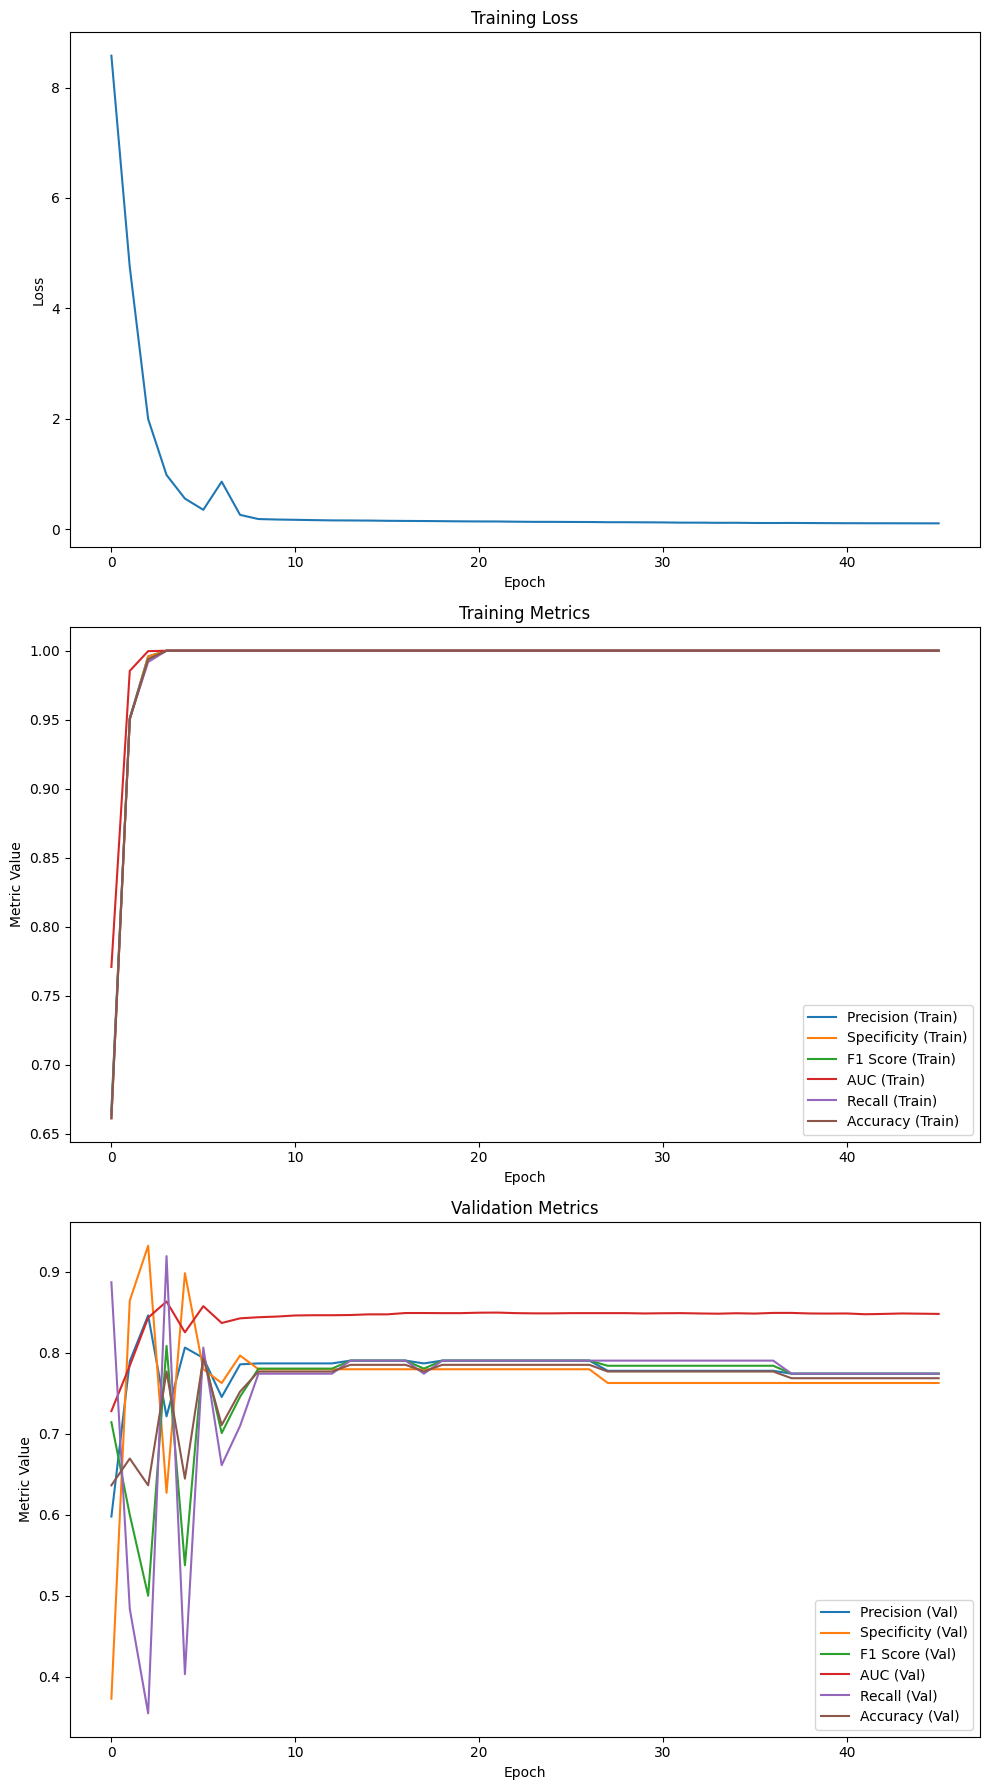

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from tqdm import tqdm
import os
import time


config = Config()
model = ConvNeXtV2MAE(config).to(config.device)

optimizer = optim.AdamW(
    model.parameters(), 
    lr=config.learning_rate, 
    weight_decay=config.weight_decay
)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=40
)

start_epoch = 0
best_val_metrics = 0.0
best_val_precision = 0.0
best_val_specificity = 0.0
best_val_f1 = 0.0
best_val_auc = 0.0
best_val_recall = 0.0
best_val_accuracy = 0.0
counter = 0
train_losses = []
train_precisions = []
train_specificities = []
train_f1s = []
train_aucs = []
train_recalls = []
train_accuracies = []
val_precisions = []
val_specificities = []
val_f1s = []
val_aucs = []
val_recalls = []
val_accuracies = []

checkpoint_path = os.path.join(config.save_dir, 'checkpoint.pth')
best_model_dir = config.save_dir
os.makedirs(best_model_dir, exist_ok=True)

if config.resume_training:
    checkpoint = torch.load(config.best_model_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    start_epoch = checkpoint['epoch']
    best_val_precision = checkpoint['best_val_precision']
    best_val_specificity = checkpoint['best_val_specificity']
    best_val_f1 = checkpoint.get('best_val_f1', 0.0)
    best_val_auc = checkpoint.get('best_val_auc', 0.0)
    best_val_recall = checkpoint.get('best_val_recall', 0.0)
    best_val_accuracy = checkpoint.get('best_val_accuracy', 0.0)
    train_losses = checkpoint.get('train_losses', [])
    train_precisions = checkpoint.get('train_precisions', [])
    train_specificities = checkpoint.get('train_specificities', [])
    train_f1s = checkpoint.get('train_f1s', [])
    train_aucs = checkpoint.get('train_aucs', [])
    train_recalls = checkpoint.get('train_recalls', [])
    train_accuracies = checkpoint.get('train_accuracies', [])
    val_precisions = checkpoint.get('val_precisions', [])
    val_specificities = checkpoint.get('val_specificities', [])
    val_f1s = checkpoint.get('val_f1s', [])
    val_aucs = checkpoint.get('val_aucs', [])
    val_recalls = checkpoint.get('val_recalls', [])
    val_accuracies = checkpoint.get('val_accuracies', [])

for epoch in range(start_epoch, config.num_epochs):
    model.train()
    epoch_loss = 0.0
    all_mae = []
    all_cls = []
    all_preds = []
    all_labels = []
    all_probs = []
    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{config.num_epochs}')
    
    for i, (c_img, w_img, labels) in enumerate(progress_bar):
        c_img, w_img, labels = c_img.to(config.device), w_img.to(config.device), labels.to(config.device)
        optimizer.zero_grad(set_to_none=True)
        loss_dict, _, _ = model(c_img, w_img, labels)
        loss = loss_dict['total_loss']
        loss.backward()
        optimizer.step()

        logits = model.forward_classification(c_img, w_img)
        probs = torch.softmax(logits, dim=1)[:, 1]
        preds = torch.argmax(logits, dim=1)

        all_preds.extend(preds.detach().cpu().numpy())
        all_labels.extend(labels.detach().cpu().numpy())
        all_probs.extend(probs.detach().cpu().numpy())
        epoch_loss += loss.item()
        all_mae.append(loss_dict['mae_loss'].item())
        all_cls.append(loss_dict['cls_loss'].item())
        
        if (i+1) % 20 == 0 or i == len(train_loader)-1:
            cls = loss_dict['cls_loss'].item()
            progress_bar.set_postfix(loss=f"{loss.item():.4f}", cls=f"{cls:.4f}", mae=f"{loss_dict['mae_loss'].item():.4f}")
    
    train_loss = epoch_loss / len(train_loader)
    train_losses.append(train_loss)
    avg_cls = np.mean(all_cls)
    avg_mae = np.mean(all_mae)
    train_precision = precision_score(all_labels, all_preds)
    train_recall = recall_score(all_labels, all_preds)
    train_f1 = f1_score(all_labels, all_preds)
    train_auc = roc_auc_score(all_labels, all_probs) 
    cm = confusion_matrix(all_labels, all_preds)
    tn, fp, fn, tp = cm.ravel()
    train_specificity = tn / (tn + fp) 
    train_accuracy = (tp + tn) / (tp + tn + fp + fn) 

    train_precisions.append(train_precision)
    train_specificities.append(train_specificity)
    train_f1s.append(train_f1)
    train_aucs.append(train_auc)
    train_recalls.append(train_recall)
    train_accuracies.append(train_accuracy)
    
    print(f"\nEpoch {epoch+1} - Train: cls={avg_cls:.4f}, mae={avg_mae:.4f}, loss={train_loss:.4f}, "
          f"precision={train_precision:.4f}, specificity={train_specificity:.4f}, "
          f"recall={train_recall:.4f}, f1={train_f1:.4f}, auc={train_auc:.4f}, accuracy={train_accuracy:.4f}")

    model.eval()
    all_preds, all_labels, all_probs, all_mae_val, all_cls_val = [], [], [], [], []
    with torch.no_grad():  
        for c_img, w_img, labels in val_loader:
            c_img, w_img, labels = c_img.to(config.device), w_img.to(config.device), labels.to(config.device)
            loss_dict, pred, mask = model(c_img, w_img, labels)
            logits = model.forward_classification(c_img, w_img)
            probs = torch.softmax(logits, dim=1)[:, 1]
            preds = torch.argmax(logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            all_mae_val.append(loss_dict['mae_loss'].item())
            all_cls_val.append(loss_dict['cls_loss'].item())

    avg_cls_val = np.mean(all_cls_val)
    avg_mae_val = np.mean(all_mae_val)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    if len(np.unique(all_labels)) > 1:
        auc = roc_auc_score(all_labels, all_probs)
    else:
        auc = 0.0
    cm = confusion_matrix(all_labels, all_preds)
    if cm.shape == (2, 2):
        tn, fp, fn, tp = cm.ravel()
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0
        accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0.0
    else:
        specificity = 0.0
        accuracy = 0.0

    val_precisions.append(precision)
    val_specificities.append(specificity)
    val_f1s.append(f1)
    val_aucs.append(auc)
    val_recalls.append(recall)
    val_accuracies.append(accuracy)
    
    print(f"Epoch {epoch+1} - Val: cls={avg_cls_val:.4f}, mae={avg_mae_val:.4f}, "
          f"precision={precision:.4f}, specificity={specificity:.4f}, "
          f"recall={recall:.4f}, f1={f1:.4f}, auc={auc:.4f}, accuracy={accuracy:.4f}")
    
    composite_metric = precision * specificity * recall
    scheduler.step(composite_metric)

    is_best = composite_metric > best_val_metrics
    if is_best:
        best_val_metrics = composite_metric
        best_val_precision = precision
        best_val_specificity = specificity
        best_val_f1 = f1
        best_val_auc = auc
        best_val_recall = recall
        best_val_accuracy = accuracy
        counter = 0
        model_path = os.path.join(best_model_dir,
                                 f"best_model_p{precision:.4f}_s{specificity:.4f}_f1{f1:.4f}.pth")
        torch.save(model.state_dict(), model_path)
        print(f"★ Saved best model: {os.path.basename(model_path)}")
    else:
        counter += 1

    if (epoch+1) % 5 == 0 or is_best:
        checkpoint = {
            'epoch': epoch+1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'best_val_precision': best_val_precision,
            'best_val_specificity': best_val_specificity,
            'best_val_f1': best_val_f1,
            'best_val_auc': best_val_auc,
            'best_val_recall': best_val_recall,
            'best_val_accuracy': best_val_accuracy,
            'train_losses': train_losses,
            'train_precisions': train_precisions,
            'train_specificities': train_specificities,
            'train_f1s': train_f1s,
            'train_aucs': train_aucs,
            'train_recalls': train_recalls,
            'train_accuracies': train_accuracies,
            'val_precisions': val_precisions,
            'val_specificities': val_specificities,
            'val_f1s': val_f1s,
            'val_aucs': val_aucs,
            'val_recalls': val_recalls,
            'val_accuracies': val_accuracies,
        }
        torch.save(checkpoint, checkpoint_path)
        print(f"Checkpoint saved at epoch {epoch+1}")

    if counter >= config.patience:
        print(f"Early stopping at epoch {epoch+1}: No improvement in composite metric for {config.patience} epochs")
        break

print(f"Training completed. Best metrics: precision={best_val_precision:.4f}, specificity={best_val_specificity:.4f}, "
      f"f1={best_val_f1:.4f}, auc={best_val_auc:.4f}, recall={best_val_recall:.4f}, accuracy={best_val_accuracy:.4f}")

def plot_training_metrics(train_losses, train_precisions, train_specificities, train_f1s, train_aucs, train_recalls, train_accuracies,
                         val_precisions, val_specificities, val_f1s, val_aucs, val_recalls, val_accuracies):
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 18))
    ax1.plot(train_losses)
    ax1.set_title('Training Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax2.plot(train_precisions, label='Precision (Train)')
    ax2.plot(train_specificities, label='Specificity (Train)')
    ax2.plot(train_f1s, label='F1 Score (Train)')
    ax2.plot(train_aucs, label='AUC (Train)')
    ax2.plot(train_recalls, label='Recall (Train)')
    ax2.plot(train_accuracies, label='Accuracy (Train)')
    ax2.set_title('Training Metrics')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Metric Value')
    ax2.legend()

    ax3.plot(val_precisions, label='Precision (Val)')
    ax3.plot(val_specificities, label='Specificity (Val)')
    ax3.plot(val_f1s, label='F1 Score (Val)')
    ax3.plot(val_aucs, label='AUC (Val)')
    ax3.plot(val_recalls, label='Recall (Val)')
    ax3.plot(val_accuracies, label='Accuracy (Val)')
    ax3.set_title('Validation Metrics')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Metric Value')
    ax3.legend()
    
    plt.tight_layout()
    plt.savefig(os.path.join(config.save_dir, 'metrics.png'))
    plt.show()
plot_training_metrics(train_losses, train_precisions, train_specificities, train_f1s, train_aucs, train_recalls, train_accuracies,
                     val_precisions, val_specificities, val_f1s, val_aucs, val_recalls, val_accuracies)